# Лекция 10. Симметричная задача на собственные значения и вычисление сингулярного разложения

## На прошлой лекции

- Собственные векторы и собственные значения
- Степенной метод и его сходимость
- Разложение Шура

## План на сегодня

- QR алгоритм
- Ускорение QR алгоритма
- Концепция сдвигов
- Подход "разделяй и властвуй" к вычислению сингулярных чисел
- Бисекция
- Метод Якоби

## QR алгоритм

- QR алгоритм был предложен в 1961 г. независимо В. Н. Кублановской и J. Francis'ом. Статью про историю этого алгоритма и его авторов можно прочитать [тут](https://www.atm.org.uk/write/MediaUploads/Resources/Mid_Plenary_FrancisGolub.pdf).   

- <font color='red'> **Не путайте** QR алгоритм и QR разложение! </font>

- QR разложение – это представление матрицы в виде произведения двух матриц, а QR алгоритм использует QR разложение для вычисления разложения Шура.


##  Путь к QR алгоритму

Рассмотрим выражение

$$A = Q T Q^*,$$

и перепишем его в виде

$$
   Q T = A Q.
$$

Слева замечаем QR разложение матрицы $AQ$.

Используем его чтобы записать одну итерацию метода неподвижной точки для разложения Шура.

## Вывод QR алгоритма из уравнения неподвижной точки

Запишем следующий итерационный процесс 

$$
    Q_{k+1} R_{k+1} = A Q_k, \quad Q_{k+1}^* A = R_{k+1} Q^*_k
$$

Введём новую матрицу

$$A_k = Q^* _k A Q_k = Q^*_k Q_{k+1} R_{k+1} = \widehat{Q}_k R_{k+1}$$

тогда аппроксимация для $A_{k+1}$ имеет вид

$$A_{k+1} = Q^*_{k+1} A Q_{k+1} = ( Q_{k+1}^* A = R_{k+1} Q^*_k)  = R_{k+1} \widehat{Q}_k.$$

Итак, мы получили стандартную форму записи QR алгоритма.

Финальные формулы обычно записывают в **QRRQ**-форме:

1. Инициализируем $A_0 = A$.
2. Вычислим QR разложение матрицы $A_k$: $A_k = Q_k R_k$.
3. Обновим аппроксимацию $A_{k+1} = R_k Q_k$.

Продолжаем итерации пока $A_k$ не станет достаточно треугольной (например, норма подматрицы под главной диагональю не станет достаточно мала).

## Что известно о сходимости и сложности

**Утверждение**

Матрицы $A_k$ унитарно подобны матрице $A$

$$A_k = Q^*_{k-1} A_{k-1} Q_{k-1} = (Q_{k-1} \ldots Q_1)^* A (Q_{k-1} \ldots Q_1)$$

а произведение унитарных матриц – унитарная матрица.

Сложность одной итерации $\mathcal{O}(n^3)$, если используется QR разложение для общего случая.

Мы ожидаем, что $A_k$ будет **очень близка к треугольной матрице** для достаточно большого $k$.

In [22]:
import numpy as np
n = 4
# a0 = [[1.0/(i + j + 0.5) for i in range(n)] for j in range(n)]
gen = np.random.default_rng(4)
a0 = gen.standard_normal((n, n))
niters = 500
u = np.eye(n)
a = a0.copy()
# print(np.tril(a, -1))
for k in range(niters):
    q, rmat = np.linalg.qr(a)
    u = u @ q
    a = rmat @ q
#     print(np.linalg.norm(np.tril(a, -1)))
#     print(a)
#     print("\n")
# print('Leading 3x3 block of a:')
print(a)
print(np.linalg.norm(a0 - u @ a @ u.T))
print(np.linalg.eigvals(a0))

[[-8.07867416e-02 -2.02956894e+00  2.02636273e+00 -8.39159028e-01]
 [ 1.64309728e+00  5.93171356e-01 -1.38274468e-01 -9.39745008e-01]
 [-1.02630855e-27  3.11344265e-27  1.60319931e+00  2.01732760e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.84468297e-01]]
4.180036692041127e-14
[ 0.25619231+1.79477696j  0.25619231-1.79477696j -0.2844683 +0.j
  1.60319931+0.j        ]


In [23]:
np.linalg.eigvals(a[:2, :2])

array([0.25619231+1.79477696j, 0.25619231-1.79477696j])

## Сходимость и сложность QR алгоритма

- QR алгоритм сходится от первого диагонального элемента к последнему.

- По крайней мере 2-3 итерации необходимо для определения каждого диагонального элемента матрицы $T$. 

- Каждый шаг состоит в вычислении QR разложения и одного произведения двух матриц, в результате имеем сложность $\mathcal{O}(n^3)$.

**Q**: означает ли это итоговую сложность $\mathcal{O}(n^4)$? 

**A**: к счастью, нет! 

- Мы можем ускорить QR алгоритм, используя сдвиги, поскольку матрица $A_k - \lambda I$ имеет те же векторы Шура (столбцы матрицы $U$).

## Верхне-гессенбергова форма матрицы

Матрица $A$ имеет верхне-гессенбергову форму, если

$$a_{ij} = 0, \; \mbox{при  } i \geq j+2.$$

$$H = \begin{bmatrix} * & * & * & * & * \\ * & * & * & * & * \\ 0 & * & * & * & *\\ 0 & 0 & * & * & *\\ 0 & 0 & 0 & * & * \\ \end{bmatrix}.$$

## Приведение произвольной матрицы к верхне-гессенберговой форме

С помощью отражений Хаусхолдера можно привести любую матрицу к верхне-гессенберговой форме:

$$U^* A U = H.$$

- Единственное отличие от вычисления разложения Шура заключается в занулении последних $n-2, n-3, ...$ элементов в первом, втором и так далее столбцах

- Сложность такого приведения $\mathcal{O}(n^3)$ операций

- Если матрица приведена к верхне-гессенберговой форме, то одна итерация QR алгоритма имеет сложность $\mathcal{O}(n^2)$ операций (например, используя вращения Гивенса) (почему?)

- Также верхне-гессенбергова форма матрицы сохраняется после выполнения одной итерации QR алгоритма (проверьте!).

[[ 0.40404544 -0.68115067 -1.44291755 -1.38341555 -1.557348  ]
 [ 2.11355221 -0.91475536  0.25040629  0.02628086  0.97571563]
 [ 0.          0.02725153 -0.8894954  -1.47939413 -0.48596562]
 [ 0.          0.         -1.07381753  2.08923048 -0.3515029 ]
 [ 0.          0.          0.          0.1108717   1.21835145]]
Matrix Q
[[-1.87768630e-01  9.80741683e-01 -3.59925659e-02  3.98776355e-02
   1.73278675e-03]
 [-9.82213287e-01 -1.87487305e-01  6.88065910e-03 -7.62336357e-03
  -3.31254930e-04]
 [-0.00000000e+00 -5.47198504e-02 -6.68668601e-01  7.40845286e-01
   3.21916502e-02]
 [-0.00000000e+00 -0.00000000e+00 -7.42657050e-01 -6.69040620e-01
  -2.90715512e-02]
 [-0.00000000e+00 -0.00000000e+00  0.00000000e+00 -4.34116311e-02
   9.99057271e-01]]
Matrix A1 after iteration of QR algorithm
[[-0.60408216 -2.3041865  -0.10593652 -0.20273784 -0.67537763]
 [ 0.48916091  0.17071352  1.89282922 -0.11335256 -1.69021265]
 [ 0.         -0.07912015 -0.5863112   1.38583964  0.70959309]
 [ 0.          0. 

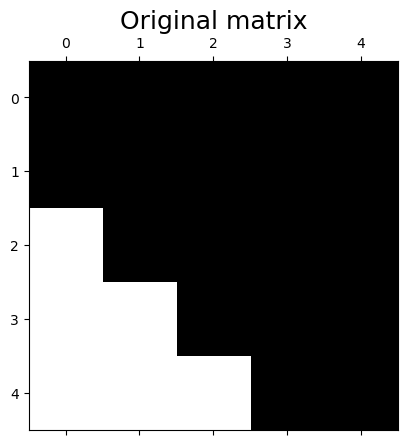

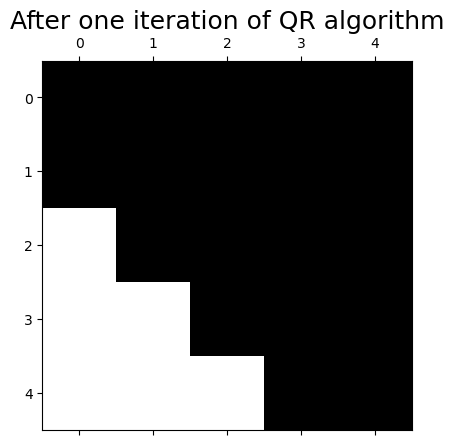

In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#Generate a random tridiagonal matrix
n = 5
A = np.random.randn(n, n)
A = np.triu(A)
sub_diag = np.random.randn(n-1)
A = A + np.diag(sub_diag, -1)
print(A)
plt.spy(A)
plt.title("Original matrix", fontsize=18)
q, r = np.linalg.qr(A)
print("Matrix Q")
print(q)
plt.figure()
b = r.dot(q)
b[abs(b) <= 1e-12] = 0
plt.spy(b)
plt.title("After one iteration of QR algorithm", fontsize=18)
#plt.figure()
#plt.imshow(np.abs(r.dot(q)))
print("Matrix A1 after iteration of QR algorithm")
print(b)

## Случай симметричной (эрмитовой) матрицы

- Если матрица $A$ симметричная (эрмитова), то $A = A^*$, тогда $H = H^*$ и верхне-гессенбергова форма оказывается трёхдиагональной матрицей

- Далее мы будем говорить только о симметричном трёхдиагональном виде верхне-гессенберговой формы

- Любая эрмитова матрица может быть приведена к трёхдиагональной форме с помощью отражений Хаусхолдера

- **Основная идея:** трёхдиагональная форма сохраняется при выполнении QR алгоритма, и сложность одной итерации может быть сокращена до $\mathcal{O}(n)$!

## Одна итерация QR алгоритма

- Одна итерация QR алгоритма имеет следующий вид:

$$A_k = Q_k R_k, \quad A_{k+1} = R_k Q_k.$$

- Если $A_0 = A$ <font color='red'> симметричная трёхдиагональная матрица </font>, то эта форма сохраняется.

- Давайте это проверим!

array([[-0.585892  ,  1.08016532,  0.        ,  0.        ,  0.        ],
       [ 1.08016532,  0.06307442,  0.94951806,  0.        ,  0.        ],
       [ 0.        ,  0.94951806, -0.61240386,  0.85254918,  0.        ],
       [ 0.        ,  0.        ,  0.85254918, -0.64092725,  0.59764326],
       [ 0.        ,  0.        ,  0.        ,  0.59764326,  0.11730961]])

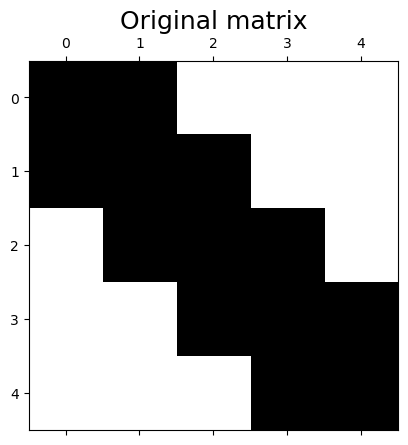

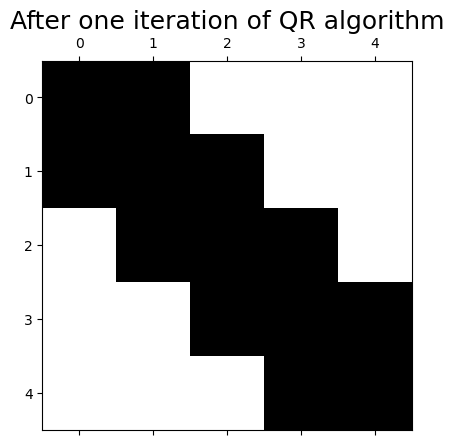

In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#Generate a random tridiagonal matrix
n = 5
d = np.random.randn(n)
sub_diag = np.random.randn(n-1)

mat = np.diag(d) + np.diag(sub_diag, -1) + np.diag(sub_diag, 1)
plt.spy(mat)
plt.title("Original matrix", fontsize=18)
q, r = np.linalg.qr(mat)
plt.figure()
b = r.dot(q)
b[abs(b) <= 1e-12] = 0
plt.spy(b)
plt.title("After one iteration of QR algorithm", fontsize=18)
#plt.figure()
#plt.imshow(np.abs(r.dot(q)))
b

## Трёхдиагональная форма

- Работая с трёхдиагональной формой, вам не нужно вычислять матрицу $Q$: нужно лишь вычислить трёхдиагональную часть, которая получается после итерации 

    $$A_k = Q_k R_k, \quad A_{k+1}  = R_k Q_k,$$

    в случае $A_k = A^*_k$.

- Такая матрица определяется $\mathcal{O}(n)$ параметрами
- Вычисление QR разложения более сложное, но возможно вычислить $A_{k+1}$ напрямую без вычисления $Q_k$.
- Это называется **неявный QR-шаг**.

## Теорема о неявном QR алгоритме


- Все реализации неявного QR алгоритма основаны на следующей теореме 

**Теорема.** Пусть 

$$Q^* A Q = H$$ 

верхне-гессенбергова форма матрицы.
Тогда первый столбец матрицы $Q$ определяет все остальные её столбцы. Он может быть найден из следующего уравнения

$$A Q = Q H. $$


## Сходимость QR алгоритма

- Сходимость QR алгоритма – непростой вопрос (см. Е.Е. Тыртышников "Краткий курс численного анализа")! 


**Итог.** Если у нас есть разложение вида

$$A = X \Lambda X^{-1}, \quad A = \begin{bmatrix}A_{11} & A_{12} \\ A_{21} & A_{22}\end{bmatrix}$$

и

$$
\Lambda = \begin{bmatrix} \Lambda_1 & 0 \\ 
0 & \Lambda_2 \end{bmatrix}, \quad \lambda(\Lambda_1)=\{\lambda_1,\dots,\lambda_m\}, \ \lambda(\Lambda_2)=\{\lambda_{m+1},\dots,\lambda_r\},
$$

а также есть **зазор** между собственными значениями в матрице $\Lambda_1$ и $\Lambda_2$ ($|\lambda_1|\geq \dots \geq |\lambda_m| > |\lambda_{m+1}| \geq\dots \geq |\lambda_r| >0$), тогда блок $A^{(k)}_{21}$  матрицы $A_k$
сходится к нулевому в процессе работы QR алгоритма со скоростью

$$\Vert A^{(k)}_{21} \Vert \leq  C q^k, \quad q = \left| \frac{\lambda_{m+1}}{\lambda_{m}}  \right |,$$

где $m$ размер матрицы $\Lambda_1$.

Таким образом, нам нужно увеличить зазор между $\Lambda_1$ и $\Lambda_2$. Это можно сделать с помощью **QR алгоритма со сдвигами**.

## QR алгоритм со сдвигами

$$A_{k} - s_k I = Q_k R_k, \quad A_{k+1} = R_k Q_k + s_k I$$


- Сходимость такого алгоритма линейная с фактором

$$\left| \frac{\lambda_{m+1} - s_k}{\lambda_{m} - s_k}  \right |,$$

где $\lambda_m$ – $m$-ое большее по модулю собственное значение. Если сдвиг близок к собственному вектору, сходимость более быстрая.

- Существуют различные стратегии выбора сдвигов. 

- Использование сдвигов – это общий подход к ускорению сходимости итерационных методов вычисления собственных значений. Далее покажем, как выбирать сдвиги для более простых алгоритмов

## Сдвиги и степенной метод

Напоминаем, что такое степенной метод для вычисления собственых значений.

$$x_{k+1} := A x_k, \quad x_{k+1} := \frac{x_{k+1}}{\Vert x_{k+1} \Vert}.$$

- Он сходится к собственному вектору, соответствующему максимальному по модулю собственному значению.

- Сходимость может быть очень медленной.

- Используем сдвиги: если мы преобразуем матрицу

$$  A := A - \lambda_k I,$$

то соответствующее собственное значение уменьшится (а нам нужно максимальное по модулю). Это не то, что нам было нужно!

## Обратная итерация и итерация Релея

- Для того чтобы из малого собственного значения сделать большое, нам нужно **обратить матрицу**, и это приводит нас к **методу обратной итерации**

$$x_{k+1} = (A - \lambda I)^{-1} x_k,$$

где $\lambda$ – сдвиг, который близок к собственному значению, которое мы хотим найти. Аналогично степенному методу сходимость линейная.

- Для ускорения сходимости можно использовать **итерацию Релея**, которая задаётся с помощью **адаптивного выбора** параметра сдвига:

$$x_{k+1} = (A - \lambda_k I)^{-1} x_k,$$

$$\lambda_k = \frac{(Ax_k, x_k)}{(x_k, x_k)}$$

В симметричном случае $A = A^*$ сходимость **локально кубическая**, и **локально квадратичная** иначе.

## Сингулярные значения и собственные значения (1)


- Сингулярное разложение имеет вид

$$A = U \Sigma V^*$$

и существует для любой матрицы.

- Его также можно считать способом приведения данной матрицы к диагональному виду с помощью двух унитарных преобразований:

$$\Sigma = U^* A V.$$

- С помощью двусторонних преобразований Хаусхолдера мы можем привести любую матрицу к **бидиагональной форме** $B$.

## Сингулярные значения и собственные значения (2)

**Неявный QR алгоритм** (со сдвигами) вычисляет собственные значения (разложение Шура).
Но мы не можем применить его напрямую к бидиагональной матрице, поскольку она может быть недиагонализуема в общем случае.

Однако задачу вычисления сингулярного разложения можно свести к **симметричной задаче на собственные значения** двумя способами:

1. Работать с трёхдиагональной матрицей

$$T = B^* B$$ 

2. Работать с расширенной матрицей 

$$T = \begin{bmatrix} 0 & B \\ B^* & 0 \end{bmatrix}$$


Случай 1 практически реализуем, если **не формировать матрицу $T$ явно**!

Таким образом, задача вычисления сингулярных чисел может быть сведена к задаче вычисления собственных чисел симметричной трёхдиагональной матрицы.

## Алгоритмы для симметричной задачи на собственные значения

Рассмотрены:

- QR алгоритм: "золотой стандарт" для вычисления собственных значений
- Метод итерации Релея

Далее:

- Алгоритм на основе стратегии "разделяй и властвуй"
- Метод бисекции
- Метод Якоби

## Метод разделяй и властвуй

Пусть у нас есть трёхдиагональная матрица и мы разделили её на блоки:


$$T = \begin{bmatrix} T'_1 & B \\ B^{\top} & T'_2 \end{bmatrix}$$

Можем записать матрицу $T$ в виде

$$T = \begin{bmatrix} T_1 & 0 \\ 0 & T_2 \end{bmatrix} + b_m v v^*$$

где $vv^*$ – матрица ранга 1, $v = (0,\dots,0,1,1,0,\dots,0)^T$.

Пусть мы уже разложили матрицы $T_1$ и $T_2$:

$$T_1 = Q_1 \Lambda_1 Q^*_1, \quad T_2 = Q_2 \Lambda_2 Q^*_2$$

Тогда (проверьте!),

$$\begin{bmatrix} Q^*_1 & 0 \\ 0 & Q^*_2 \end{bmatrix} T\begin{bmatrix} Q_1 & 0 \\ 0 & Q_2 \end{bmatrix} = D + \rho u u^{*}, \quad D = \begin{bmatrix} \Lambda_1 & 0 \\ 0 & \Lambda_2\end{bmatrix},$$

то есть мы свели задачу к задаче вычисления собственных значений у матрицы вида


<font color='red'> диагональная матрица плюс матрица малого ранга. </font>



## Матрица вида диагональная матрица плюс матрица малого ранга

- Собственные значения матрицы  вида

$$D + \rho u u^* $$

вычислить не так просто!

- Характеристический многочлен имеет вид

$$\det(D + \rho uu^* - \lambda I) = \det(D - \lambda I)\det(I + \rho (D - \lambda I)^{-1} uu^*) = 0.$$

Тогда (докажите!!) 

$$\det(I + \rho (D - \lambda I)^{-1} uu^*) = 1 + \rho \sum_{i=1}^n \frac{|u_i|^2}{d_i - \lambda} = 0$$

Подсказка: найдите $\det(I + w u^*)$ используя два факта: 
- $\text{det}(C) = \prod_{i=1}^n\lambda_i(C)$
- $\text{trace}(C) = \sum_{i=1}^n \lambda_i$.

## Характеристическое уравнение

$$1 + \rho \sum_{i=1}^n \frac{|u_i|^2}{d_i - \lambda} = 0$$

Как найти корни?

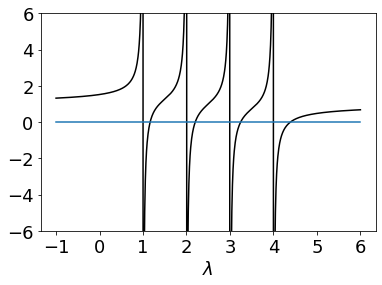

In [2]:
import numpy as np

lm = [1, 2, 3, 4]
M = len(lm)
D = np.array(lm)
a = np.min(lm)
b = np.max(lm)
t = np.linspace(-1, 6, 1000)
u = 0.5 * np.ones(M)
rho = 1
def fun(lam):
    return 1 + rho * np.sum(u**2/(D - lam))
res = [fun(lam) for lam in t]
plt.plot(t, res, 'k')
plt.plot(t, np.zeros_like(t))
plt.ylim([-6, 6])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
_ = plt.xlabel("$\lambda$", fontsize=18)

- Эта функция имеет только один корень на каждом отрезке $[d_i, d_{i+1}]$

- Мы показали справедливость теоремы Коши о чередовании (что происходит с собственными числами после внесения возмущения ранга 1)

## Как найти корни

- Метод Ньютона не сработает (изобразите касательные к графику).

- Заметим, что метод Ньютона – это по сути линейная аппроксимация функции $f(\lambda)$ на каждой итерации.

- Лучше аппроксимировать с помощью **гиперболы** вида:

$$f(\lambda) \approx c_0 + \frac{c_1}{d_i - \lambda} + \frac{c_2}{d_{i+1} - \lambda}.$$

- Для вычисления коэффициентов нам нужно вычислить $f(\lambda)$ и $f'(\lambda)$  в некоторых точках.

- После чего получить апроксимацию из решения **квадратного уравнения**

## Важный недостаток метода

- Устойчивость: этот метод игнорировали долгое время из-за неустойчивого вычисления собственных векторов.

- Нам нужно вычислить собственные векторы матрицы $D + \rho uu^*$.

- Точное выражение для собственных векторов $v_i$, для которых найдены собственные значения $\alpha_i$:

$$(D + \rho uu^*)v_i = \alpha_i v_i \qquad (D - \alpha_i I)v_i + \rho (u^*v_i) u  = 0$$

То есть $v_i \in \mathrm{span}(\{(D - \alpha_i I)^{-1}u\})$.

- Причины неустойчивости:
    - если есть два близких собственных числа $\alpha_i$ и $\alpha_{i+1}$, то соответствующие векторы $(D - \alpha_i I)^{-1}u$ и $(D - \alpha_{i+1} I)^{-1}u$ будут близки, хотя долждны быть ортогональны
    - если $\alpha_i$ и $\alpha_{i+1}$ очень близки, то они близки к числу $d_i$ между ними, то есть матрицы $D - \alpha_i I$ и $D - \alpha_{i+1} I$ близки к вырожденным

## Теорема Лёвнера (Charles Loewner)

- Решение проблемы неустойчивости можно получить с помощью теоремы Лёвнера:

Если $\alpha_i$ и $d_i$ удовлетворяют **теореме о чередовании** 


$$d_n < \alpha_n < \ldots < d_{i+1} < \alpha_{i+1} \ldots$$

Тогда существует вектор $\widehat{u}$ такой что $\alpha_i$ – точное собственное значение матрицы

$$\widehat{D} = D + \widehat{u} \widehat{u}^*$$

и 

$$ \widehat{u}^2_i = \frac{\prod_{j=1}^n (\alpha_j - d_i)}{\prod_{j=1, j \neq i}^n (d_j - d_i)}  $$

- Использование вектора $\widehat{u}$ вместо $u$ даёт устойчивое вычисление собственного вектора!
- Таким образом, сначала вычисляются собственные значения, затем $\widehat{u}$ и только потом собственные векторы.

## Ещё несколько алгоритмов

- Абсолютно другой подход основан на идеи **бисекции**

- Дана матрица $A$, инерция которой определяется как триплет $(\nu, \zeta, \pi)$, где $\nu$ – число отрицательных, $\zeta$ - число нулевых, и $\pi$ - число положительных собственных значений. 

- Если $X$ невырождена, тогда

$$Inertia(A) = Inertia(X^* A X)$$

## Бисекция с помощью метода Гаусса

- Для данного $z$ мы можем запустить метод Гаусса и получить разложение:

$$A - zI = L D L^*,$$

а инерция для диагональной матрицы вычисляется просто.

- С помощью инерции мы можем легко посчитать число собственных значений в заданном интервале.
- Пример: если $Inertia(A)=(5,0,2)$ и после сдвига $Inertia(A-zI)=(4,0,3)$, $z\in[a,b]$ тогда это значит, что $\lambda(A)\in[a,z]$.

## Метод Якоби

- Вспомним что такое вращения Гивенса (Якоби):

на плоскости им соответствуют ортогональные матрицы $2 \times 2$ вида

$$\begin{pmatrix} \cos \phi & \sin \phi \\ -\sin \phi & \cos \phi \end{pmatrix},$$

а в $n$-мерном пространстве мы выбираем два индекса $i$ и $j$ и вращаем относительно соответствующих элементов $n$-мерного вектора.

## Метод Якоби: продолжение

- Идея метода Якоби состоит в минимизации суммы квадратов недиагональных элементов:

$$\Gamma(A) = \mathrm{off}( U^* A U), \quad \mathrm{off}^2(X) = \sum_{i \ne j} \left|X_{ij}\right|^2 = \|X \|^2_F - \sum\limits_{i=1}^n x^2_{ii}$$

с помощью последовательных вращений Якоби для их зануления. 

- Когда элементы выбраны, их легко занулить.

- **Главный вопрос:** в каком порядке нужно проводить зануление?

- Если мы всегда зануляем максимальный недиагональный элемент, метод имеет глобально линейную сходимость и локально квадратичную.

- На практике используется циклический порядок (то есть, $(1, 2), (1, 3), \ldots, (2, 3), \ldots$).

## Главное про метод Якоби

Метод Якоби был первым численным методом для вычисления собственных значений, предложен в 1846.

- Большая константа в оценке сложности
- Очень точный (высокая относительная точность для малых собственных значений по сравнению с другими методами)
- Хорошая возможность параллелизации

## Главное по сегодняшней лекции

- Методы решения симметричной задачи на собстенные значения
- Использование сдвигов для ускорения сходимости
- Способы вычисления сингулярного разложения

## Выводы по способам вычисления разложений

- LU и QR разложения можно вычислить с помощью **прямых** методов за конечное число операций.

- SVD и разложение Шура не могут быть вычислены с помощью прямых методов (почему?). Они могут быть получены с помощью **итерационных методов**

- Однако итерационные методы также имеют сложность $\mathcal{O}(n^3)$ операций благодаря быстрой сходимости.